In [403]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [462]:
df = pd.read_csv('datasets/draft1_cleaned_train.csv')

In [463]:
df.head(2)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,0.0,13517,Pave,None,IR1,Lvl,...,0,0,No Pool,No Fence,No Addl Features,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,None,IR1,Lvl,...,0,0,No Pool,No Fence,No Addl Features,0,4,2009,WD,220000


Looking at the columns to consider what's most interesting to me. I want to create a 'has garage', 'has basement', 'has masonry vnr', and 'has pool' to see if there may be benefits to that versus all the details about those categories. I'd add 'Has Frontage' but I'm not certain that's what those NAs meant, so I don't want to turn that into a binary.

In [464]:
df.columns.tolist()

['id',
 'pid',
 'ms_subclass',
 'ms_zoning',
 'lot_frontage',
 'lot_area',
 'street',
 'alley',
 'lot_shape',
 'land_contour',
 'utilities',
 'lot_config',
 'land_slope',
 'neighborhood',
 'condition_1',
 'condition_2',
 'bldg_type',
 'house_style',
 'overall_qual',
 'overall_cond',
 'year_built',
 'year_remod/add',
 'roof_style',
 'roof_matl',
 'exterior_1st',
 'exterior_2nd',
 'mas_vnr_type',
 'mas_vnr_area',
 'exter_qual',
 'exter_cond',
 'foundation',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_sf_1',
 'bsmtfin_type_2',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 'heating',
 'heating_qc',
 'central_air',
 'electrical',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abvgr',
 'kitchen_abvgr',
 'kitchen_qual',
 'totrms_abvgrd',
 'functional',
 'fireplaces',
 'fireplace_qu',
 'garage_type',
 'garage_yr_blt',
 'garage_finish',
 'garage_cars',
 'garage_are

-----

# "Has (FEATURE)" Columns
I created several "has_(FEATURE)" columns to see if simply having the feature moved the needle in the model. It turned out not, but I think it was worth exploring.

To do this, I found `df.loc[(df.name == None) & (df.weight == 1), 'name'] = 'defaut'` at [this site](https://stackoverflow.com/questions/44641577/how-to-change-value-for-rows-that-meet-specific-conditions-in-pandas) and modified it to make the changes I want.

In [465]:
df['bsmt_qual'].value_counts()

TA             886
Gd             849
Ex             177
Fa              60
No Basement     55
Po               1
Name: bsmt_qual, dtype: int64

In [466]:
df['has_bsmt'] = 0

df.loc[(df['bsmt_qual'] != 'No Basement'), 'has_bsmt'] = 1

In [467]:
df['has_bsmt'].value_counts()

1    1973
0      55
Name: has_bsmt, dtype: int64

In [468]:
df['garage_qual'].value_counts()

TA           1810
No Garage     113
Fa             82
Gd             18
Ex              3
Po              2
Name: garage_qual, dtype: int64

In [469]:
df['has_garage'] = 0

df.loc[(df['garage_qual'] != 'No Garage'), 'has_garage']=1

In [470]:
df['has_garage'].value_counts()

1    1915
0     113
Name: has_garage, dtype: int64

In [471]:
df['mas_vnr_type'].value_counts()

None       1218
BrkFace     629
Stone       168
BrkCmn       13
Name: mas_vnr_type, dtype: int64

In [472]:
df['has_mas_vnr'] = 0

df.loc[(df['mas_vnr_type'] != 'None'), 'has_mas_vnr'] = 1

In [473]:
df['has_mas_vnr'].value_counts()

0    1218
1     810
Name: has_mas_vnr, dtype: int64

In [474]:
df['pool_qc'].value_counts()

No Pool    2019
Gd            4
Fa            2
TA            2
Ex            1
Name: pool_qc, dtype: int64

In [475]:
df['has_pool'] = 0
df.loc[(df['pool_qc'] != 'No Pool'), 'has_pool'] = 1

In [476]:
df['has_pool'].value_counts()

0    2019
1       9
Name: has_pool, dtype: int64

-----

# Initial Correlation Heatmap

I didn't remember offhand that you could use `plt.figure()` to resize a seaborn plot. I checked [this site](https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn). The second answer shows the solution to resizing it that I used, which was necessary to make the figure legible.

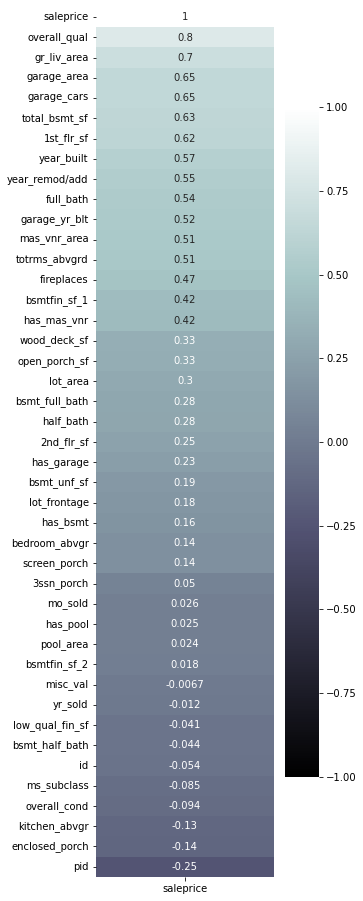

In [477]:
plt.figure(figsize = (4,16))
sns.heatmap(df.corr()[['saleprice']].sort_values(by = 'saleprice', ascending = False),
           vmin = -1,
           vmax = 1,
           annot = True,
           cmap = 'bone');

I'm interested in instantiating a model that takes into account the variables that show a correlation of above 0.5 or maybe 0.4, seeing what that looks like.

### Exploring Categorical Columns

In order to start grasping what's going on in the categorical columns, I wanted to get to a list of categorical column names. I created a data frame with the column names (as index) and data types. I used that to create a dataframe that consisted only of the categorical variables. I then turned the index for that into a list, my list of categorical columns, which I could then pass through the data frame to look at those a little more carefully.

NOTE: I returned up here repeatedly to clean out my categorical list when I recast things to numericals to make it easier to keep track of what I had left to work through.

In [478]:
column_dtype = pd.DataFrame(df.dtypes, df.columns)
column_dtype.rename(columns = {0: 'dtype'}, inplace = True)
column_dtype.dtypes

dtype    object
dtype: object

In [479]:
categorical_columns = column_dtype[(column_dtype['dtype'] != 'int64') & (column_dtype['dtype'] != 'float64')]


In [480]:
categorical_col_list = list(categorical_columns.index)
df[categorical_col_list].head()

,ms_zoning,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,...,fireplace_qu,garage_type,garage_finish,garage_qual,garage_cond,paved_drive,pool_qc,fence,misc_feature,sale_type
0,RL,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,...,No Fireplace,Attchd,RFn,TA,TA,Y,No Pool,No Fence,No Addl Features,WD
1,RL,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,...,TA,Attchd,RFn,TA,TA,Y,No Pool,No Fence,No Addl Features,WD
2,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,No Fireplace,Detchd,Unf,TA,TA,Y,No Pool,No Fence,No Addl Features,WD
3,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,...,No Fireplace,BuiltIn,Fin,TA,TA,Y,No Pool,No Fence,No Addl Features,WD
4,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,...,No Fireplace,Detchd,Unf,TA,TA,N,No Pool,No Fence,No Addl Features,WD


In [481]:
categorical_col_list

['ms_zoning',
 'street',
 'alley',
 'lot_shape',
 'land_contour',
 'utilities',
 'lot_config',
 'land_slope',
 'neighborhood',
 'condition_1',
 'condition_2',
 'bldg_type',
 'house_style',
 'roof_style',
 'roof_matl',
 'exterior_1st',
 'exterior_2nd',
 'mas_vnr_type',
 'exter_qual',
 'exter_cond',
 'foundation',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_type_2',
 'heating',
 'heating_qc',
 'central_air',
 'electrical',
 'kitchen_qual',
 'functional',
 'fireplace_qu',
 'garage_type',
 'garage_finish',
 'garage_qual',
 'garage_cond',
 'paved_drive',
 'pool_qc',
 'fence',
 'misc_feature',
 'sale_type']

## Notes on the Exploration of these Columns

**Note: Month Sold is an additional categorical column that isn't included above because it's an integer datatype.**

**I created these additional binary columns:** 
* 'has_alley' 'has_fireplace' *

**I converted the following into 0s and 1s:**
* 'street' to "street_surface", 1 is paved and 0 is gravel.
* central_air to 1 == Y and 0 == N.

**I turned the following into continuous, scaled variables:**
* Lot shape: 0 is regular, 3 is extremely irregular, and irregularity falling on a spectrum in between. 
* Land slope: 0 is gentle, 1 is moderate, and 2 is severe. This would reduce the number of features and, I think, still be effective. 
* Exterior Quality: 0 is Poor through 4 is Excellent 
* Exterior Condition: 0 is Poor through 4 is Excellent
* 'paved_drive': 0 is 'not paved', 1 is 'partially paved', and 2 is "paved".
* Kitchen Quality: 0 is Poor through 4 is Excellent
* Functionality ('Functional'): 0 is Typical, 1 is Minor Deductions 1, 2 is Minor Deductions 2, 3 is Moderate Deductions, 4 is Major Deductions 1, 5 is Major Deductions 2, 6 is Severely Damaged, 7 is Salvage only.
* Pool Quality: 0 no pool, 1 is Fair through 4 is Excellent (NOTES: because of the 'no pool' option, it's debatable whether or not this should be turned into a scale, but I'm opting to try it. Also, this scale has no 'Poor' options)
* Garage Quality: 0 no garage, 1 is poor through 5 is Excellent (NOTES: because of the 'no garage' option, it's debatable whether or not this should be turned into a scale, but I'm opting to try it.)
* Garage Condition: 0 no garage, 1 is poor through 5 is Excellent (NOTES: because of the 'no garage' option, it's debatable whether or not this should be turned into a scale, but I'm opting to try it.)

**I think the following categoricals are likely to be helpful:** 
* Neighborhood
* Zoning
* Lot Configuration
* Condition 1
* Condition 2
* Building Type
* House Style
* Miscellaneous Features (which could possibly be cast as a 'has_misc' column, too -- not doing that for now because the various features are less comparable, in my opinion, but it's an option) 
* Month sold 

**I think the following categoricals _might_ be helpful:**
* Masonry Veneer Type
* Heating Type ('heating')
* Garage details
* Pool details
* Land Contour
* Roof Style
* Roof Material
* Foundation (type)
* Electrical
* Fence

**I suspect the following would be unhelpful**
* Sale Type (I wonder if this has predictive value or if it will simply correlate, meaning that certain kinds of properties are more likely to sell in a certain kind of sale -- and at a certain price, the features of the property being a confounder if there's a correlation between Sale Type and Sale Price). That said, I'm not eliminating it right now.

**I eliminated Utilities**
* The 'utilities' column only had 2 instances that aren't full utilities, which doesn't seem robust enough to have any predictive value.

NOTE: I explored these values in the order they're in the list, then reordered the code based on what I decided to do with them.

#### A Note on how I organized my work.
I used the following code block to keep track of the categorical values I had left to decide how to deal with.

I took the list of details about the "has_(BLANK)" categories I created out in order to make the list more manageable. I left in categorical columns that I haven't used at all in the list for easy reference.

As I turned values into numericals (i.e. 0 = No, 1 = Yes; scaled ratings, etc.) and when I eliminated 'utilites', I took them out of the list to make it easier to keep track of which variables I needed to look at. 

As a result, I went back and forth to these next two blocks as I eliminated things I was working on, just to keep track.

Also, this [stackoverflow](https://stackoverflow.com/questions/52797035/how-to-remove-an-item-from-a-list-in-python-with-substring-match) gave me the idea to use a list comprehension to do this, though I varied the actual code.

In [482]:
clean_categorical_col_list = [i for i in categorical_col_list if 'bsmt' not in i and 'garage' not in i\
                             and 'utilities' not in i and 'alley' not in i and 'pool' not in i\
                             and 'fireplace' not in i and 'street' not in i and 'lot_shape' not in i\
                             and 'land_slope' not in i and 'exter' not in i and 'paved_drive' not in i\
                             and 'central_air' not in i and 'heating_qc' not in i and 'kitchen_qual' not in i\
                             and 'functional' not in i]
clean_categorical_col_list

['ms_zoning',
 'land_contour',
 'lot_config',
 'neighborhood',
 'condition_1',
 'condition_2',
 'bldg_type',
 'house_style',
 'roof_style',
 'roof_matl',
 'mas_vnr_type',
 'foundation',
 'heating',
 'electrical',
 'fence',
 'misc_feature',
 'sale_type']

In [483]:
df[clean_categorical_col_list].head()

,ms_zoning,land_contour,lot_config,neighborhood,condition_1,condition_2,bldg_type,house_style,roof_style,roof_matl,mas_vnr_type,foundation,heating,electrical,fence,misc_feature,sale_type
0,RL,Lvl,CulDSac,Sawyer,RRAe,Norm,1Fam,2Story,Gable,CompShg,BrkFace,CBlock,GasA,SBrkr,No Fence,No Addl Features,WD
1,RL,Lvl,CulDSac,SawyerW,Norm,Norm,1Fam,2Story,Gable,CompShg,BrkFace,PConc,GasA,SBrkr,No Fence,No Addl Features,WD
2,RL,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,None,CBlock,GasA,SBrkr,No Fence,No Addl Features,WD
3,RL,Lvl,Inside,Timber,Norm,Norm,1Fam,2Story,Gable,CompShg,None,PConc,GasA,SBrkr,No Fence,No Addl Features,WD
4,RL,Lvl,Inside,SawyerW,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,None,PConc,GasA,SBrkr,No Fence,No Addl Features,WD


-----

### More "Has (FEATURE)" columns
I missed a couple above.

In [484]:
df['has_alley'] = 0
df.loc[(df['alley'] != 'None'), 'has_alley'] = 1

In [485]:
df['has_alley'].value_counts()

0    1890
1     138
Name: has_alley, dtype: int64

In [486]:
df['has_fireplace'] = 0
df.loc[(df['fireplace_qu'] != 'No Fireplace'), 'has_fireplace'] = 1
df['has_fireplace'].value_counts()

1    1036
0     992
Name: has_fireplace, dtype: int64

-----

#### Turning 'Central Air' to 0 and 1

In [487]:
df['central_air'].value_counts()

Y    1887
N     141
Name: central_air, dtype: int64

In [488]:
df['central_air'] = df['central_air'].map({'Y':1, 'N': 0})
df['central_air'].value_counts()

1    1887
0     141
Name: central_air, dtype: int64

------

#### Turning 'Street' to 'Street Surface'

In [489]:
df['street'].value_counts()

Pave    2021
Grvl       7
Name: street, dtype: int64

In [490]:
df.rename(columns = {'street':'street_surface'}, inplace = True)
df['street_surface'] = df['street_surface'].map({'Pave': 1, 'Grvl': 0})
df['street_surface'].head()

0    1
1    1
2    1
3    1
4    1
Name: street_surface, dtype: int64

-----

#### Turning 'Paved Drive' to Scaled Score, 0 to 3 

In [492]:
df['paved_drive'].value_counts()

Y    1839
N     150
P      39
Name: paved_drive, dtype: int64

In [493]:
df['paved_drive'] = df['paved_drive'].map({'N': 0, 'P': 1, 'Y': 2})

In [494]:
df['paved_drive'].value_counts()

2    1839
0     150
1      39
Name: paved_drive, dtype: int64

------

#### Mapping Scoring Categoricals (Objects) to Numericals

In [495]:
df['lot_shape'].value_counts()

Reg    1284
IR1     681
IR2      54
IR3       9
Name: lot_shape, dtype: int64

In [496]:
df['lot_shape'] = df['lot_shape'].map({'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3':3})
df['lot_shape'].value_counts()

0    1284
1     681
2      54
3       9
Name: lot_shape, dtype: int64

In [497]:
df['land_slope'].value_counts()

Gtl    1930
Mod      88
Sev      10
Name: land_slope, dtype: int64

In [498]:
df['land_slope'] = df['land_slope'].map({'Gtl':0, 'Mod':1, 'Sev':2})
df['land_slope'].value_counts()

0    1930
1      88
2      10
Name: land_slope, dtype: int64

In [499]:
df['pool_qc'] = df['pool_qc'].map({'No Pool': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4})

In [500]:
df['pool_qc'].value_counts()

0    2019
3       4
1       2
2       2
4       1
Name: pool_qc, dtype: int64

In [501]:
df['garage_qual'] = df['garage_qual'].map({'No Garage': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd':4, 'Ex':5})

In [502]:
df['garage_qual'].value_counts()

3    1810
0     113
2      82
4      18
5       3
1       2
Name: garage_qual, dtype: int64

In [503]:
df['garage_cond'] = df['garage_cond'].map({'No Garage': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd':4, 'Ex':5})

In [504]:
df['garage_cond'].value_counts()

3    1846
0     113
2      47
4      12
1       8
5       2
Name: garage_cond, dtype: int64

In [505]:
df['exter_cond'].value_counts()

TA    1755
Gd     215
Fa      49
Ex       7
Po       2
Name: exter_cond, dtype: int64

In [506]:
df['exter_cond'] = df['exter_cond'].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4})

In [507]:
df['exter_cond'].value_counts()

2    1755
3     215
1      49
4       7
0       2
Name: exter_cond, dtype: int64

In [508]:
df['exter_qual'] = df['exter_qual'].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4})

In [509]:
df['exter_qual'].value_counts()

2    1246
3     676
4      80
1      26
Name: exter_qual, dtype: int64

In [510]:
df['heating_qc'].value_counts()

Ex    1043
TA     596
Gd     319
Fa      67
Po       3
Name: heating_qc, dtype: int64

In [511]:
df['heating_qc'] = df['heating_qc'].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4})

In [512]:
df['heating_qc'].value_counts()

4    1043
2     596
3     319
1      67
0       3
Name: heating_qc, dtype: int64

In [513]:
df['kitchen_qual'].value_counts()

TA    1045
Gd     789
Ex     147
Fa      47
Name: kitchen_qual, dtype: int64

In [514]:
df['kitchen_qual'] = df['kitchen_qual'].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4})

In [515]:
df['kitchen_qual'].value_counts()

2    1045
3     789
4     147
1      47
Name: kitchen_qual, dtype: int64

0 is Typical, 1 is Minor Deductions 1, 2 is Minor Deductions 2, 3 is Moderate Deductions, 4 is Major Deductions 1, 5 is Major Deductions 2, 6 is Severely Damaged, 7 is Salvage only.

In [516]:
df['functional'].value_counts()

Typ     1893
Min2      42
Min1      42
Mod       29
Maj1      11
Maj2       7
Sev        2
Sal        2
Name: functional, dtype: int64

In [517]:
df['functional'] = df['functional'].map({'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 
                                         'Maj2': 5, 'Sev': 6, 'Sal':7})

In [518]:
df['functional'].value_counts()

0    1893
2      42
1      42
3      29
4      11
5       7
6       2
7       2
Name: functional, dtype: int64

-----

#### Looking at Categoricals that Look Like They Can't be Cast to Numericals
In other words, they're not scaled ratings.

In [523]:
df['neighborhood'].value_counts()

NAmes      310
CollgCr    179
OldTown    163
Edwards    142
Somerst    120
NridgHt    119
Sawyer     111
Gilbert    111
NWAmes      87
SawyerW     86
Mitchel     82
BrkSide     76
Crawfor     70
IDOTRR      69
NoRidge     48
Timber      47
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
Veenker     17
NPkVill     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64

In [524]:
df['ms_zoning'].value_counts()

RL         1582
RM          316
FV           94
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64

In [525]:
df['lot_config'].value_counts()

Inside     1488
Corner      343
CulDSac     129
FR2          59
FR3           9
Name: lot_config, dtype: int64

In [526]:
df['land_contour'].value_counts()

Lvl    1821
HLS      84
Bnk      80
Low      43
Name: land_contour, dtype: int64

In [527]:
df['condition_1'].value_counts()

Norm      1749
Feedr      107
Artery      70
RRAn        33
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: condition_1, dtype: int64

In [528]:
df['bldg_type'].value_counts()

1Fam      1679
TwnhsE     159
Duplex      75
Twnhs       69
2fmCon      46
Name: bldg_type, dtype: int64

In [529]:
df['house_style'].value_counts()

1Story    1046
2Story     589
1.5Fin     218
SLvl        93
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: house_style, dtype: int64

In [530]:
df['roof_matl'].value_counts()

CompShg    2002
Tar&Grv      15
WdShngl       5
WdShake       4
Membran       1
ClyTile       1
Name: roof_matl, dtype: int64

In [531]:
df['roof_style'].value_counts()

Gable      1600
Hip         393
Flat         13
Gambrel      12
Mansard       7
Shed          3
Name: roof_style, dtype: int64

-----

#### Dealing with 'Utilities'
It turns out there are only two data points that are not on the public system, not enough data to be very helpful, so I removed them, ultimately.

In [533]:
df['utilities'].value_counts()

AllPub    2026
NoSeWa       1
NoSewr       1
Name: utilities, dtype: int64

In [534]:
df[df['utilities'] == 'NoSeWa']

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street_surface,alley,lot_shape,land_contour,...,mo_sold,yr_sold,sale_type,saleprice,has_bsmt,has_garage,has_mas_vnr,has_pool,has_alley,has_fireplace
553,956,916176030,20,RL,0.0,14375,1,None,1,Lvl,...,1,2009,COD,137500,1,1,1,0,0,1


In [535]:
df[df['utilities'] == 'NoSewr']

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street_surface,alley,lot_shape,land_contour,...,mo_sold,yr_sold,sale_type,saleprice,has_bsmt,has_garage,has_mas_vnr,has_pool,has_alley,has_fireplace
573,946,912251110,30,I (all),109.0,21780,0,None,0,Lvl,...,3,2009,ConLD,57625,0,1,0,0,0,0


Deleting 'utilities'.

In [536]:
df.drop(columns = 'utilities', inplace = True)

### Looking at Heatmap with New Numericals
It appears that Exterior Quality and Kitchen Quality (both ratings converted to numericals) are highly correlated to sale price.

As an observation, it's interesting to me that Exterior Quality is the second most highly correlated feature. **I wonder if it gives creedence to the importance of first impressions, that if a home creates a favorable impression when prospective buyers approach it, that creates a context in which they view the rest of the home more favorably (and are willing to pay more for it).**

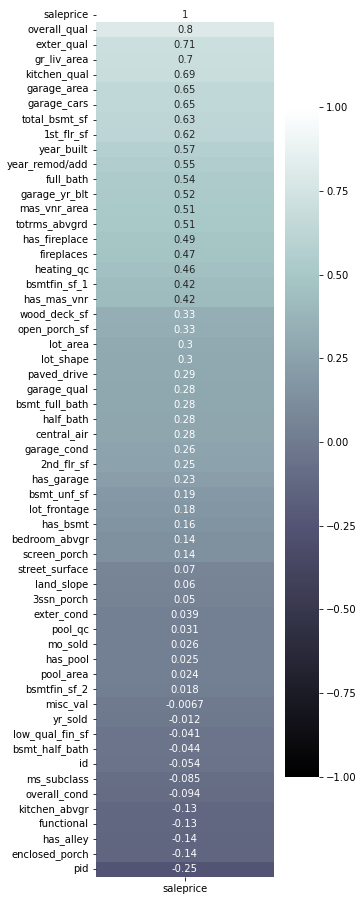

In [537]:
plt.figure(figsize = (4,16))
sns.heatmap(df.corr()[['saleprice']].sort_values(by = 'saleprice', ascending = False),
           vmin = -1,
           vmax = 1,
           annot = True,
           cmap = 'bone');

In [538]:
df.to_csv('datasets/draft2_no_dummies_train.csv', index = False)